## QSARBoost-SIRT2: Gradient Boosting–Based QSAR Modeling and Virtual Screening for SIRT2 Inhibitors

This Jupyter notebook implements the complete QSARBoost workflow for the SIRT2 case study. It covers dataset curation from ChEMBL, ECFP4 fingerprint generation, feature filtering, model training with multiple gradient boosting algorithms, hyperparameter optimization using Optuna, applicability domain assessment via Williams plot and Mahalanobis distance, and virtual screening of the DrugBank library. The notebook outputs performance metrics, diagnostic plots, and prioritized candidate compounds with predicted pIC₅₀ values and AD flags.


### 1. ChEMBL data curation

In [ ]:
import pandas as pd

# Load the CSV file
df = pd.read_csv("sirt2.csv")
df

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units
0,CHEMBL3931028,CCCCOc1c(Cl)cc(C(=O)NC(=S)Nc2ccc(NC(=O)CCCCN(C...,IC50,'=',400.00,nM
1,CHEMBL3233742,COc1cc2ccccc2c(Cc2c(-c3ccc(C)cc3)[nH][nH]c2=O)c1O,IC50,'>',200000.00,nM
2,CHEMBL3233748,CC(C)c1ccc(-c2[nH][nH]c(=O)c2Cc2c(O)ccc3nc(Cl)...,IC50,'=',68000.00,nM
3,CHEMBL520706,O=C(/C=C/c1ccccc1)NCCc1c[nH]c2ccccc12,IC50,'=',173000.00,nM
4,CHEMBL200762,CC(NC(=O)c1cccc(/N=C/c2c(O)ccc3ccccc23)c1)c1cc...,IC50,'=',35700.00,nM
...,...,...,...,...,...,...
1801,CHEMBL3237032,CN(c1ccc(Cl)cn1)S(=O)(=O)c1cccc(C(=O)Nc2ccc(C#...,IC50,'=',6100.00,nM
1802,CHEMBL1797749,O=C(Nc1cccc([N+](=O)[O-])c1)c1cccc(S(=O)(=O)N2...,IC50,'=',12500.00,nM
1803,CHEMBL2203548,C=CCN1C(=O)/C(=C/c2ccc(-c3cccc(Cl)c3Cl)o2)C(=O...,IC50,'=',2818.38,nM
1804,CHEMBL323197,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1C...,IC50,'=',9200.00,nM


In [ ]:
# Drop columns that contain any missing values
df_cleaned = df.dropna(axis=0)
df_cleaned

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units
0,CHEMBL3931028,CCCCOc1c(Cl)cc(C(=O)NC(=S)Nc2ccc(NC(=O)CCCCN(C...,IC50,'=',400.00,nM
1,CHEMBL3233742,COc1cc2ccccc2c(Cc2c(-c3ccc(C)cc3)[nH][nH]c2=O)c1O,IC50,'>',200000.00,nM
2,CHEMBL3233748,CC(C)c1ccc(-c2[nH][nH]c(=O)c2Cc2c(O)ccc3nc(Cl)...,IC50,'=',68000.00,nM
3,CHEMBL520706,O=C(/C=C/c1ccccc1)NCCc1c[nH]c2ccccc12,IC50,'=',173000.00,nM
4,CHEMBL200762,CC(NC(=O)c1cccc(/N=C/c2c(O)ccc3ccccc23)c1)c1cc...,IC50,'=',35700.00,nM
...,...,...,...,...,...,...
1801,CHEMBL3237032,CN(c1ccc(Cl)cn1)S(=O)(=O)c1cccc(C(=O)Nc2ccc(C#...,IC50,'=',6100.00,nM
1802,CHEMBL1797749,O=C(Nc1cccc([N+](=O)[O-])c1)c1cccc(S(=O)(=O)N2...,IC50,'=',12500.00,nM
1803,CHEMBL2203548,C=CCN1C(=O)/C(=C/c2ccc(-c3cccc(Cl)c3Cl)o2)C(=O...,IC50,'=',2818.38,nM
1804,CHEMBL323197,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1C...,IC50,'=',9200.00,nM


In [ ]:
df_cleaned['standard_relation'].unique()

array(["'='", "'>'", "'<'", "'>='"], dtype=object)

In [ ]:
df_cleaned.loc[:, 'standard_relation'] = df_cleaned['standard_relation'].str.replace("'", "").str.strip()

In [ ]:
df_cleaned = df_cleaned[df_cleaned['standard_relation'] == '=']
df_cleaned

,molecule_chembl_id,smiles,standard_type,standard_relation,standard_value,standard_units
0,CHEMBL3931028,CCCCOc1c(Cl)cc(C(=O)NC(=S)Nc2ccc(NC(=O)CCCCN(C...,IC50,=,400.00,nM
2,CHEMBL3233748,CC(C)c1ccc(-c2[nH][nH]c(=O)c2Cc2c(O)ccc3nc(Cl)...,IC50,=,68000.00,nM
3,CHEMBL520706,O=C(/C=C/c1ccccc1)NCCc1c[nH]c2ccccc12,IC50,=,173000.00,nM
4,CHEMBL200762,CC(NC(=O)c1cccc(/N=C/c2c(O)ccc3ccccc23)c1)c1cc...,IC50,=,35700.00,nM
6,CHEMBL491960,O=c1[nH]c(=S)[nH]c(-c2ccccc2)c1Cc1c(O)ccc2ccccc12,IC50,=,59000.00,nM
...,...,...,...,...,...,...
1801,CHEMBL3237032,CN(c1ccc(Cl)cn1)S(=O)(=O)c1cccc(C(=O)Nc2ccc(C#...,IC50,=,6100.00,nM
1802,CHEMBL1797749,O=C(Nc1cccc([N+](=O)[O-])c1)c1cccc(S(=O)(=O)N2...,IC50,=,12500.00,nM
1803,CHEMBL2203548,C=CCN1C(=O)/C(=C/c2ccc(-c3cccc(Cl)c3Cl)o2)C(=O...,IC50,=,2818.38,nM
1804,CHEMBL323197,COc1c(O)cc2oc3cc(O)c(CC=C(C)C)c(O)c3c(=O)c2c1C...,IC50,=,9200.00,nM


In [ ]:
from rdkit import Chem, RDLogger
from rdkit.Chem import SaltRemover
from rdkit.Chem.MolStandardize import rdMolStandardize

# Silence RDKit logs
RDLogger.DisableLog('rdApp.*')

remover = SaltRemover.SaltRemover()
normalizer = rdMolStandardize.Normalizer()
uncharger = rdMolStandardize.Uncharger()
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()

def standardize_smiles(smiles):
    if pd.isnull(smiles):
        return smiles
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = remover.StripMol(mol)
    mol = normalizer.normalize(mol)
    mol = uncharger.uncharge(mol)
    mol = tautomer_enumerator.Canonicalize(mol)
    return Chem.MolToSmiles(mol, canonical=True)

df_cleaned['smiles'] = df_cleaned['smiles'].apply(standardize_smiles)

/tmp/ipykernel_3362/3304305514.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['smiles'] = df_cleaned['smiles'].apply(standardize_smiles)


In [ ]:
# Group by canonical_smiles and compute mean IC50
df_grouped = df_cleaned.groupby('smiles', as_index=False)['standard_value'].mean()

In [ ]:
# Merge with original data (to retain molecular weight etc.)
df_clean_final = df_grouped.merge(df_cleaned.drop(columns=['standard_value', 'pIC50'], errors='ignore'),
                                  on='smiles', how='left').drop_duplicates('smiles')

# Now calculate pIC50
import numpy as np
df_clean_final['pIC50'] = -np.log10(df_clean_final['standard_value'] * 1e-9)  # assuming standard_value is in nM
df_clean_final.reset_index()

,index,smiles,standard_value,molecule_chembl_id,standard_type,standard_relation,standard_units,pIC50
0,0,BrCCCCc1nc(-c2ccc(Br)cc2)no1,2600.000,CHEMBL4104964,IC50,=,nM,5.585027
1,1,BrCCCc1nc(-c2ccc(Br)cc2)no1,1500.000,CHEMBL4072206,IC50,=,nM,5.823909
2,2,C#CCOc1cccc(Cc2cnc(NC(=O)CSc3nc(C)cc(C)n3)s2)c1,2400.000,CHEMBL4227975,IC50,=,nM,5.619789
3,3,C#Cc1ccc(C(=O)Nc2cccc(COc3cncc(C(N)=O)c3)c2)cc1,41.500,CHEMBL3805831,IC50,=,nM,7.381952
4,4,C/C=C/C(=O)Nc1ccc(OCc2cccc(NC(=O)CSc3nc(C)cc(C...,89212.545,CHEMBL4170003,IC50,=,nM,4.049574
...,...,...,...,...,...,...,...,...
944,1243,Oc1cccc(/C=N/c2ccc(/N=C/c3cccc(O)c3)c3ccccc23)c1,195900.000,CHEMBL220300,IC50,=,nM,3.707966
945,1244,Oc1ccccc1C=Nc1ccc(N=Cc2ccccc2O)cc1,58400.000,CHEMBL373990,IC50,=,nM,4.233587
946,1245,S=c1[nH]c2ccc(Cl)nc2[nH]1,26900.000,CHEMBL1797922,IC50,=,nM,4.570248
947,1246,S=c1[nH]c2ccc3ccccc3c2[nH]1,10000.000,CHEMBL1456134,IC50,=,nM,5.000000


### 2. Molecular fingerprints generation

In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from tqdm import tqdm

# ECFP4 generator
def get_ecfp4_array(smiles, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
        return list(fp)
    else:
        return None

# Enable tqdm progress
tqdm.pandas()

# Apply on your final dataset with progress bar
df_clean_final['ecfp4'] = df_clean_final['smiles'].progress_apply(get_ecfp4_array)

# Drop any failed rows
df_clean_final = df_clean_final[df_clean_final['ecfp4'].notnull()].reset_index(drop=True)

# Expand fingerprints to 2048 columns
fp_df = pd.DataFrame(df_clean_final['ecfp4'].to_list(), columns=[f'fp_{i}' for i in range(2048)])

# Join and save
df_final = pd.concat([df_clean_final.drop(columns=['ecfp4']), fp_df], axis=1)
df_final.to_csv("sirt2_ecfp4.csv", index=False)

100%|███████████████████████████████████████████████████████████████████████████████| 949/949 [00:00<00:00, 1409.25it/s]


### 3. Model construction

In [ ]:
import pandas as pd
df_final = pd.read_csv("sirt2_ecfp4.csv")
df_final

,smiles,standard_value,molecule_chembl_id,standard_type,standard_relation,standard_units,pIC50,fp_0,fp_1,fp_2,...,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047
0,BrCCCCc1nc(-c2ccc(Br)cc2)no1,2600.000,CHEMBL4104964,IC50,=,nM,5.585027,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BrCCCc1nc(-c2ccc(Br)cc2)no1,1500.000,CHEMBL4072206,IC50,=,nM,5.823909,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C#CCOc1cccc(Cc2cnc(NC(=O)CSc3nc(C)cc(C)n3)s2)c1,2400.000,CHEMBL4227975,IC50,=,nM,5.619789,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C#Cc1ccc(C(=O)Nc2cccc(COc3cncc(C(N)=O)c3)c2)cc1,41.500,CHEMBL3805831,IC50,=,nM,7.381952,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C/C=C/C(=O)Nc1ccc(OCc2cccc(NC(=O)CSc3nc(C)cc(C...,89212.545,CHEMBL4170003,IC50,=,nM,4.049574,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Oc1cccc(/C=N/c2ccc(/N=C/c3cccc(O)c3)c3ccccc23)c1,195900.000,CHEMBL220300,IC50,=,nM,3.707966,0,0,0,...,0,0,0,0,0,0,0,0,0,0
945,Oc1ccccc1C=Nc1ccc(N=Cc2ccccc2O)cc1,58400.000,CHEMBL373990,IC50,=,nM,4.233587,0,0,0,...,0,0,0,0,0,0,0,0,0,0
946,S=c1[nH]c2ccc(Cl)nc2[nH]1,26900.000,CHEMBL1797922,IC50,=,nM,4.570248,0,0,0,...,0,0,0,0,0,0,0,0,0,0
947,S=c1[nH]c2ccc3ccccc3c2[nH]1,10000.000,CHEMBL1456134,IC50,=,nM,5.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd

# 1. Define target
y = df_final['pIC50']

# 2. Define features: drop 'pIC50' and any non-descriptor column (e.g. 'smiles' if exists)
X = df_final.drop(columns=['pIC50', 'smiles', 'standard_value','molecule_chembl_id','standard_type','standard_relation','standard_units'], errors='ignore')

In [ ]:
# 3. Binning for stratification
bins, bin_edges = pd.qcut(y, q=5, labels=False, retbins=True)
print(bin_edges)

# 4. Train-test split with stratification
X_main, X_holdout, y_main, y_holdout = train_test_split(
    X, y, test_size=0.2, stratify=bins, random_state=42)

[ 2.34678749  4.44953076  4.9837216   5.42852466  6.24321244 10.15490196]


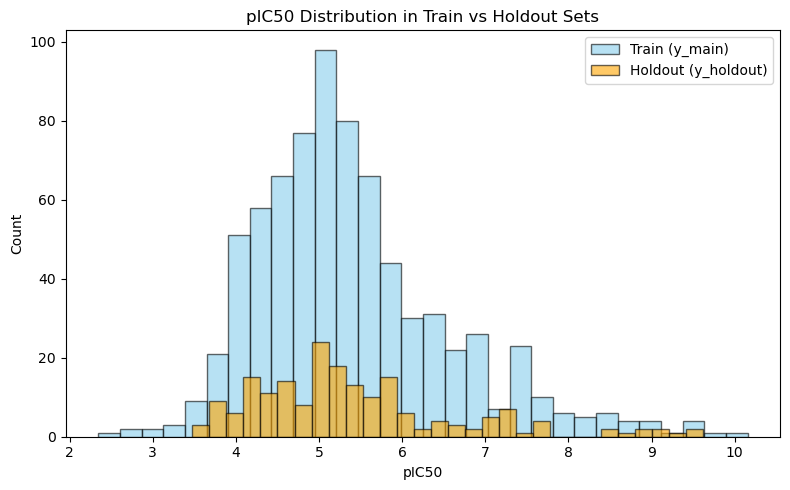

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.hist(y_main, bins=30, alpha=0.6, label="Train (y_main)", color="skyblue", edgecolor="black")
plt.hist(y_holdout, bins=30, alpha=0.6, label="Holdout (y_holdout)", color="orange", edgecolor="black")
plt.xlabel("pIC50")
plt.ylabel("Count")
plt.title("pIC50 Distribution in Train vs Holdout Sets")
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.feature_selection import VarianceThreshold
import numpy as np

# 1. Drop low-variance features
var_thresh = VarianceThreshold(threshold=0.1)
X_main_var = var_thresh.fit_transform(X_main)

# Get kept feature names
kept_var_cols = X_main.columns[var_thresh.get_support()]

# 2. Drop highly correlated features
X_main_var_df = pd.DataFrame(X_main_var, columns=kept_var_cols)

corr_matrix = X_main_var_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

# Final cleaned feature set
X_main_clean = X_main_var_df.drop(columns=to_drop)

# Align holdout set
X_holdout_clean = X_holdout[kept_var_cols].drop(columns=to_drop)

In [ ]:
X_main_clean.shape, X_holdout_clean.shape, y_main.shape, y_holdout.shape

((759, 84), (190, 84), (759,), (190,))

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor

# Assume X_main_clean and y_main are already defined
X_clean = X_main_clean
y = y_main

# Binning for stratification
bins_main = pd.qcut(y, q=5, labels=False)
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define models
models = {
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "XGBoost": XGBRegressor(random_state=42, n_jobs=-1),
    "LightGBM": LGBMRegressor(random_state=42, n_jobs=-1, verbose=-1),
    "CatBoost": CatBoostRegressor(random_state=42, verbose=0)
}

# Evaluate each model
for name, model in models.items():
    r2_train_scores, rmse_train_scores, mae_train_scores, mse_train_scores = [], [], [], []
    r2_val_scores, rmse_val_scores, mae_val_scores, mse_val_scores = [], [], [], []

    for train_idx, test_idx in skf.split(X_clean, bins_main):
        X_train, X_val = X_clean.iloc[train_idx], X_clean.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]

        model.fit(X_train, y_train)

        y_train_pred = model.predict(X_train)
        y_val_pred = model.predict(X_val)

        r2_train_scores.append(r2_score(y_train, y_train_pred))
        rmse_train_scores.append(np.sqrt(mean_squared_error(y_train, y_train_pred)))
        mae_train_scores.append(mean_absolute_error(y_train, y_train_pred))
        mse_train_scores.append(mean_squared_error(y_train, y_train_pred))

        r2_val_scores.append(r2_score(y_val, y_val_pred))
        rmse_val_scores.append(np.sqrt(mean_squared_error(y_val, y_val_pred)))
        mae_val_scores.append(mean_absolute_error(y_val, y_val_pred))
        mse_val_scores.append(mean_squared_error(y_val, y_val_pred))

    print(f"\n{name} CV Results:")
    print(f"Train R²:  {np.mean(r2_train_scores):.3f} ± {np.std(r2_train_scores):.3f}")
    print(f"Val   R²:  {np.mean(r2_val_scores):.3f} ± {np.std(r2_val_scores):.3f}")
    print(f"Train RMSE: {np.mean(rmse_train_scores):.3f}, Val RMSE: {np.mean(rmse_val_scores):.3f}")
    print(f"Train MAE:  {np.mean(mae_train_scores):.3f}, Val MAE:  {np.mean(mae_val_scores):.3f}")
    print(f"Train MSE:  {np.mean(mse_train_scores):.3f}, Val MSE:  {np.mean(mse_val_scores):.3f}")


GradientBoosting CV Results:
Train R²:  0.813 ± 0.006
Val   R²:  0.641 ± 0.045
Train RMSE: 0.509, Val RMSE: 0.702
Train MAE:  0.397, Val MAE:  0.530
Train MSE:  0.260, Val MSE:  0.497

XGBoost CV Results:
Train R²:  0.983 ± 0.001
Val   R²:  0.628 ± 0.130
Train RMSE: 0.153, Val RMSE: 0.709
Train MAE:  0.082, Val MAE:  0.506
Train MSE:  0.023, Val MSE:  0.523

LightGBM CV Results:
Train R²:  0.899 ± 0.003
Val   R²:  0.679 ± 0.060
Train RMSE: 0.375, Val RMSE: 0.663
Train MAE:  0.285, Val MAE:  0.495
Train MSE:  0.141, Val MSE:  0.445

CatBoost CV Results:
Train R²:  0.959 ± 0.001
Val   R²:  0.712 ± 0.061
Train RMSE: 0.238, Val RMSE: 0.627
Train MAE:  0.177, Val MAE:  0.463
Train MSE:  0.056, Val MSE:  0.401


### 4. Best model tuning

In [ ]:
import optuna
from catboost import CatBoostRegressor
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import make_scorer, r2_score
import numpy as np
import pandas as pd

# Binning target for stratification
bins = pd.qcut(y_main, q=5, labels=False)
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

def objective(trial):
    params = {
        "iterations": trial.suggest_int("iterations", 200, 1000),
        "depth": trial.suggest_int("depth", 4, 10),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1.0, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0, 1),
        "border_count": trial.suggest_int("border_count", 32, 255),
        "random_strength": trial.suggest_float("random_strength", 1e-9, 10.0, log=True),
        "verbose": 0,
        "task_type": "CPU",
        "random_seed": 42
    }

    model = CatBoostRegressor(**params)
    scores = cross_val_score(
        model,
        X_main_clean,
        y_main,
        cv=cv.split(X_main_clean, bins),
        scoring=make_scorer(r2_score),
        n_jobs=-1
    )
    return scores.mean()

study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=50, show_progress_bar=True)

print("Best CV R²:", study.best_value)
print("Best parameters:", study.best_params)

/home/yassir/miniconda/envs/cdd/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[I 2025-07-02 10:20:05,309] A new study created in memory with name: no-name-d9842b18-68de-47fe-b232-e2862e85716a
Best trial: 0. Best value: 0.701685:   2%|▉                                              | 1/50 [00:05<04:23,  5.38s/it]

[I 2025-07-02 10:20:10,691] Trial 0 finished with value: 0.7016854269772199 and parameters: {'iterations': 393, 'depth': 6, 'learning_rate': 0.02435872837690697, 'l2_leaf_reg': 1.236122962083067, 'bagging_temperature': 0.15338369180174982, 'border_count': 38, 'random_strength': 0.3388737052523206}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 0. Best value: 0.701685:   4%|█▉                                             | 2/50 [00:13<05:46,  7.23s/it]

[I 2025-07-02 10:20:19,205] Trial 1 finished with value: 0.6914563309989162 and parameters: {'iterations': 704, 'depth': 6, 'learning_rate': 0.17512261387499164, 'l2_leaf_reg': 6.553150990226873, 'bagging_temperature': 0.464506647756767, 'border_count': 74, 'random_strength': 1.625099325294125e-07}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 0. Best value: 0.701685:   6%|██▊                                            | 3/50 [00:17<04:29,  5.73s/it]

[I 2025-07-02 10:20:23,149] Trial 2 finished with value: 0.6071608909273739 and parameters: {'iterations': 341, 'depth': 6, 'learning_rate': 0.01279647493093882, 'l2_leaf_reg': 7.264672069859632, 'bagging_temperature': 0.4654106131546356, 'border_count': 245, 'random_strength': 0.04878779387452404}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 0. Best value: 0.701685:   8%|███▊                                           | 4/50 [00:33<07:16,  9.49s/it]

[I 2025-07-02 10:20:38,411] Trial 3 finished with value: 0.6932769730649353 and parameters: {'iterations': 476, 'depth': 7, 'learning_rate': 0.022001158499438688, 'l2_leaf_reg': 3.9643958165875777, 'bagging_temperature': 0.6230697929779071, 'border_count': 134, 'random_strength': 2.8954028001636266e-07}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 0. Best value: 0.701685:  10%|████▋                                          | 5/50 [01:11<15:00, 20.01s/it]

[I 2025-07-02 10:21:17,084] Trial 4 finished with value: 0.6978794327445766 and parameters: {'iterations': 791, 'depth': 8, 'learning_rate': 0.05718407266027125, 'l2_leaf_reg': 3.948269168824056, 'bagging_temperature': 0.6124153715033983, 'border_count': 245, 'random_strength': 2.025788083541839e-09}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 0. Best value: 0.701685:  12%|█████▋                                         | 6/50 [02:03<22:40, 30.92s/it]

[I 2025-07-02 10:22:09,166] Trial 5 finished with value: 0.692807847825154 and parameters: {'iterations': 530, 'depth': 10, 'learning_rate': 0.06392786969631087, 'l2_leaf_reg': 6.596885687091646, 'bagging_temperature': 0.0590311771920744, 'border_count': 234, 'random_strength': 5.864803555208437e-08}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 0. Best value: 0.701685:  14%|██████▌                                        | 7/50 [02:06<15:29, 21.61s/it]

[I 2025-07-02 10:22:11,626] Trial 6 finished with value: 0.6948575791205309 and parameters: {'iterations': 340, 'depth': 5, 'learning_rate': 0.1267079976329084, 'l2_leaf_reg': 6.554454946256448, 'bagging_temperature': 0.7371781815806154, 'border_count': 240, 'random_strength': 0.12765480311299576}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 0. Best value: 0.701685:  16%|███████▌                                       | 8/50 [02:09<10:56, 15.63s/it]

[I 2025-07-02 10:22:14,454] Trial 7 finished with value: 0.6935653490100213 and parameters: {'iterations': 388, 'depth': 5, 'learning_rate': 0.1814644274850589, 'l2_leaf_reg': 6.981034313091702, 'bagging_temperature': 0.7061680434135491, 'border_count': 252, 'random_strength': 3.6581485169778833}. Best is trial 0 with value: 0.7016854269772199.


Best trial: 8. Best value: 0.71057:  18%|████████▋                                       | 9/50 [02:17<09:03, 13.26s/it]

[I 2025-07-02 10:22:22,500] Trial 8 finished with value: 0.710570433556916 and parameters: {'iterations': 393, 'depth': 6, 'learning_rate': 0.13466616212719257, 'l2_leaf_reg': 2.299054485343148, 'bagging_temperature': 0.4652502652375722, 'border_count': 158, 'random_strength': 6.23298304237586}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  20%|█████████▍                                     | 10/50 [02:36<09:59, 15.00s/it]

[I 2025-07-02 10:22:41,379] Trial 9 finished with value: 0.6969140360134572 and parameters: {'iterations': 916, 'depth': 7, 'learning_rate': 0.10242434558109537, 'l2_leaf_reg': 1.5248725902595472, 'bagging_temperature': 0.9281433534756522, 'border_count': 82, 'random_strength': 8.312051901842198e-05}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  22%|██████████▎                                    | 11/50 [02:37<06:57, 10.69s/it]

[I 2025-07-02 10:22:42,318] Trial 10 finished with value: 0.6509332161299358 and parameters: {'iterations': 212, 'depth': 4, 'learning_rate': 0.08685967139315066, 'l2_leaf_reg': 9.637732520253383, 'bagging_temperature': 0.2700714774753512, 'border_count': 173, 'random_strength': 0.0004172335881730816}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  24%|███████████▎                                   | 12/50 [02:51<07:35, 11.98s/it]

[I 2025-07-02 10:22:57,253] Trial 11 finished with value: 0.6727826865937144 and parameters: {'iterations': 212, 'depth': 9, 'learning_rate': 0.029710893691010123, 'l2_leaf_reg': 1.538317826490201, 'bagging_temperature': 0.0360136473178323, 'border_count': 141, 'random_strength': 8.320198121890051}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  26%|████████████▏                                  | 13/50 [03:00<06:43, 10.91s/it]

[I 2025-07-02 10:23:05,701] Trial 12 finished with value: 0.7045075076652015 and parameters: {'iterations': 629, 'depth': 6, 'learning_rate': 0.03238676360939228, 'l2_leaf_reg': 3.0130488747717643, 'bagging_temperature': 0.22115343249624214, 'border_count': 33, 'random_strength': 0.06399084875101144}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  28%|█████████████▏                                 | 14/50 [03:03<05:12,  8.68s/it]

[I 2025-07-02 10:23:09,234] Trial 13 finished with value: 0.680915053320154 and parameters: {'iterations': 649, 'depth': 4, 'learning_rate': 0.03717165910199982, 'l2_leaf_reg': 3.273077236470059, 'bagging_temperature': 0.30838256231423455, 'border_count': 176, 'random_strength': 0.00586356074044976}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  30%|██████████████                                 | 15/50 [03:26<07:34, 12.98s/it]

[I 2025-07-02 10:23:32,185] Trial 14 finished with value: 0.6971745612987424 and parameters: {'iterations': 571, 'depth': 8, 'learning_rate': 0.01454130006702302, 'l2_leaf_reg': 2.776771441014302, 'bagging_temperature': 0.26049971743051564, 'border_count': 99, 'random_strength': 0.001240712942186637}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  32%|███████████████                                | 16/50 [03:32<06:06, 10.77s/it]

[I 2025-07-02 10:23:37,814] Trial 15 finished with value: 0.6954757775986903 and parameters: {'iterations': 784, 'depth': 5, 'learning_rate': 0.04867419667186925, 'l2_leaf_reg': 4.765539415111107, 'bagging_temperature': 0.3819167632454076, 'border_count': 188, 'random_strength': 1.6204331631036423e-05}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  34%|███████████████▉                               | 17/50 [04:10<10:26, 18.98s/it]

[I 2025-07-02 10:24:15,879] Trial 16 finished with value: 0.7011639987867161 and parameters: {'iterations': 960, 'depth': 8, 'learning_rate': 0.07389731352775072, 'l2_leaf_reg': 2.6390954266501723, 'bagging_temperature': 0.17553804228764802, 'border_count': 35, 'random_strength': 1.5668544488529332}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  36%|████████████████▉                              | 18/50 [04:16<08:00, 15.02s/it]

[I 2025-07-02 10:24:21,683] Trial 17 finished with value: 0.6705643141463622 and parameters: {'iterations': 477, 'depth': 6, 'learning_rate': 0.018145762474047058, 'l2_leaf_reg': 5.519187019205135, 'bagging_temperature': 0.3828071822191724, 'border_count': 114, 'random_strength': 0.014372777382152658}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  38%|█████████████████▊                             | 19/50 [04:30<07:36, 14.71s/it]

[I 2025-07-02 10:24:35,684] Trial 18 finished with value: 0.707982080625889 and parameters: {'iterations': 678, 'depth': 7, 'learning_rate': 0.03998786958689203, 'l2_leaf_reg': 2.2449608778290977, 'bagging_temperature': 0.5634244403671733, 'border_count': 189, 'random_strength': 0.5777241138235691}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  40%|██████████████████▊                            | 20/50 [05:31<14:21, 28.70s/it]

[I 2025-07-02 10:25:36,987] Trial 19 finished with value: 0.7089716093828015 and parameters: {'iterations': 740, 'depth': 9, 'learning_rate': 0.11951740788594593, 'l2_leaf_reg': 2.1552417965225463, 'bagging_temperature': 0.8974696364503796, 'border_count': 201, 'random_strength': 0.4770210572309807}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  42%|███████████████████▋                           | 21/50 [06:58<22:16, 46.10s/it]

[I 2025-07-02 10:27:03,651] Trial 20 finished with value: 0.7046393624990186 and parameters: {'iterations': 851, 'depth': 10, 'learning_rate': 0.13466397964833365, 'l2_leaf_reg': 8.409063731248684, 'bagging_temperature': 0.964040832650972, 'border_count': 207, 'random_strength': 7.85759815556876}. Best is trial 8 with value: 0.710570433556916.


Best trial: 8. Best value: 0.71057:  44%|████████████████████▋                          | 22/50 [07:53<22:43, 48.71s/it]

[I 2025-07-02 10:27:58,431] Trial 21 finished with value: 0.7074011078752092 and parameters: {'iterations': 699, 'depth': 9, 'learning_rate': 0.1126960119283476, 'l2_leaf_reg': 2.2666883990744626, 'bagging_temperature': 0.7691352866805663, 'border_count': 207, 'random_strength': 0.4629741927889158}. Best is trial 8 with value: 0.710570433556916.


Best trial: 22. Best value: 0.713745:  46%|████████████████████▋                        | 23/50 [08:09<17:30, 38.90s/it]

[I 2025-07-02 10:28:14,461] Trial 22 finished with value: 0.7137446104403379 and parameters: {'iterations': 719, 'depth': 7, 'learning_rate': 0.04334212561966087, 'l2_leaf_reg': 2.0114725920579333, 'bagging_temperature': 0.8306192837510915, 'border_count': 156, 'random_strength': 0.4881783104663169}. Best is trial 22 with value: 0.7137446104403379.


Best trial: 22. Best value: 0.713745:  48%|█████████████████████▌                       | 24/50 [09:05<19:03, 43.99s/it]

[I 2025-07-02 10:29:10,339] Trial 23 finished with value: 0.689021889305828 and parameters: {'iterations': 742, 'depth': 9, 'learning_rate': 0.08054666467175682, 'l2_leaf_reg': 4.7624911713743465, 'bagging_temperature': 0.8851301143935346, 'border_count': 156, 'random_strength': 0.0058843731172174615}. Best is trial 22 with value: 0.7137446104403379.


Best trial: 22. Best value: 0.713745:  50%|██████████████████████▌                      | 25/50 [09:26<15:29, 37.19s/it]

[I 2025-07-02 10:29:31,639] Trial 24 finished with value: 0.7008437838918424 and parameters: {'iterations': 858, 'depth': 7, 'learning_rate': 0.1446783997511591, 'l2_leaf_reg': 1.0455000662831768, 'bagging_temperature': 0.8470346856618843, 'border_count': 155, 'random_strength': 1.2966260569324517}. Best is trial 22 with value: 0.7137446104403379.


Best trial: 22. Best value: 0.713745:  52%|███████████████████████▍                     | 26/50 [09:48<13:05, 32.75s/it]

[I 2025-07-02 10:29:54,033] Trial 25 finished with value: 0.7039452686421778 and parameters: {'iterations': 578, 'depth': 8, 'learning_rate': 0.04972091646326774, 'l2_leaf_reg': 3.5594502739435896, 'bagging_temperature': 0.9880066566978295, 'border_count': 121, 'random_strength': 0.029288278518326365}. Best is trial 22 with value: 0.7137446104403379.


Best trial: 22. Best value: 0.713745:  54%|████████████████████████▎                    | 27/50 [10:45<15:17, 39.91s/it]

[I 2025-07-02 10:30:50,643] Trial 26 finished with value: 0.6877418968687998 and parameters: {'iterations': 770, 'depth': 9, 'learning_rate': 0.10144227756953529, 'l2_leaf_reg': 2.13993542727731, 'bagging_temperature': 0.7744858751608221, 'border_count': 205, 'random_strength': 7.422835547993899e-06}. Best is trial 22 with value: 0.7137446104403379.


Best trial: 22. Best value: 0.713745:  56%|█████████████████████████▏                   | 28/50 [11:23<14:23, 39.25s/it]

[I 2025-07-02 10:31:28,354] Trial 27 finished with value: 0.6851440955881453 and parameters: {'iterations': 848, 'depth': 8, 'learning_rate': 0.1943088529070501, 'l2_leaf_reg': 4.66241391782281, 'bagging_temperature': 0.8173661296371124, 'border_count': 222, 'random_strength': 0.001016807056478866}. Best is trial 22 with value: 0.7137446104403379.


Best trial: 22. Best value: 0.713745:  58%|██████████████████████████                   | 29/50 [11:28<10:08, 28.97s/it]

[I 2025-07-02 10:31:33,357] Trial 28 finished with value: 0.7075447273138142 and parameters: {'iterations': 502, 'depth': 5, 'learning_rate': 0.06901798122510316, 'l2_leaf_reg': 1.8577293932025387, 'bagging_temperature': 0.6660816241979743, 'border_count': 159, 'random_strength': 0.24648826672429466}. Best is trial 22 with value: 0.7137446104403379.


Best trial: 29. Best value: 0.713821:  60%|███████████████████████████                  | 30/50 [11:54<09:27, 28.36s/it]

[I 2025-07-02 10:32:00,274] Trial 29 finished with value: 0.713820577750063 and parameters: {'iterations': 1000, 'depth': 7, 'learning_rate': 0.024668952307045428, 'l2_leaf_reg': 1.231682949069723, 'bagging_temperature': 0.5680333981736728, 'border_count': 175, 'random_strength': 1.6459198286946015}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  62%|███████████████████████████▉                 | 31/50 [12:20<08:40, 27.42s/it]

[I 2025-07-02 10:32:25,509] Trial 30 finished with value: 0.7047273146906863 and parameters: {'iterations': 971, 'depth': 7, 'learning_rate': 0.010052997491115696, 'l2_leaf_reg': 1.2132583463047935, 'bagging_temperature': 0.561119683525936, 'border_count': 125, 'random_strength': 1.5643384721794877}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  64%|████████████████████████████▊                | 32/50 [12:41<07:39, 25.54s/it]

[I 2025-07-02 10:32:46,650] Trial 31 finished with value: 0.7098506862824394 and parameters: {'iterations': 910, 'depth': 7, 'learning_rate': 0.024422581637085966, 'l2_leaf_reg': 1.7711559090116542, 'bagging_temperature': 0.5242679639049758, 'border_count': 170, 'random_strength': 0.2459773236185788}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  66%|█████████████████████████████▋               | 33/50 [12:56<06:21, 22.45s/it]

[I 2025-07-02 10:33:01,889] Trial 32 finished with value: 0.71019385368489 and parameters: {'iterations': 1000, 'depth': 6, 'learning_rate': 0.026133024287708365, 'l2_leaf_reg': 1.0188122705895184, 'bagging_temperature': 0.39533755685873506, 'border_count': 175, 'random_strength': 0.1317348092820776}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  68%|██████████████████████████████▌              | 34/50 [13:08<05:09, 19.32s/it]

[I 2025-07-02 10:33:13,918] Trial 33 finished with value: 0.7100694484752461 and parameters: {'iterations': 912, 'depth': 6, 'learning_rate': 0.027052787498007252, 'l2_leaf_reg': 1.0924142547697575, 'bagging_temperature': 0.41445968968614566, 'border_count': 146, 'random_strength': 8.62256192713222}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  70%|███████████████████████████████▍             | 35/50 [13:21<04:20, 17.39s/it]

[I 2025-07-02 10:33:26,811] Trial 34 finished with value: 0.7065681552845711 and parameters: {'iterations': 969, 'depth': 6, 'learning_rate': 0.020231468871965162, 'l2_leaf_reg': 2.572711939572657, 'bagging_temperature': 0.4528851090506065, 'border_count': 186, 'random_strength': 0.10579609005933242}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  72%|████████████████████████████████▍            | 36/50 [13:27<03:14, 13.89s/it]

[I 2025-07-02 10:33:32,511] Trial 35 finished with value: 0.6113883528568466 and parameters: {'iterations': 281, 'depth': 6, 'learning_rate': 0.01685514127476832, 'l2_leaf_reg': 3.532668032666568, 'bagging_temperature': 0.3372544131086518, 'border_count': 54, 'random_strength': 1.8373020029957665}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  74%|█████████████████████████████████▎           | 37/50 [13:34<02:35, 11.98s/it]

[I 2025-07-02 10:33:40,042] Trial 36 finished with value: 0.7027709144890378 and parameters: {'iterations': 996, 'depth': 5, 'learning_rate': 0.034963864478157254, 'l2_leaf_reg': 1.597521419051054, 'bagging_temperature': 0.49679251282688164, 'border_count': 167, 'random_strength': 0.01879140966253622}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  76%|██████████████████████████████████▏          | 38/50 [13:44<02:14, 11.23s/it]

[I 2025-07-02 10:33:49,515] Trial 37 finished with value: 0.6889807405722286 and parameters: {'iterations': 434, 'depth': 7, 'learning_rate': 0.02426182704385523, 'l2_leaf_reg': 5.326631784803503, 'bagging_temperature': 0.610024957857329, 'border_count': 136, 'random_strength': 0.004517852919014827}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  78%|███████████████████████████████████          | 39/50 [13:54<02:01, 11.07s/it]

[I 2025-07-02 10:34:00,222] Trial 38 finished with value: 0.6990719584608714 and parameters: {'iterations': 821, 'depth': 6, 'learning_rate': 0.05376431259715321, 'l2_leaf_reg': 3.0484385284880546, 'bagging_temperature': 0.4420436133470634, 'border_count': 151, 'random_strength': 5.123659248861162e-09}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  80%|████████████████████████████████████         | 40/50 [14:02<01:39,  9.97s/it]

[I 2025-07-02 10:34:07,606] Trial 39 finished with value: 0.6978615215192756 and parameters: {'iterations': 411, 'depth': 6, 'learning_rate': 0.04070198534333628, 'l2_leaf_reg': 4.247867766163553, 'bagging_temperature': 0.11370763736276401, 'border_count': 99, 'random_strength': 0.08204064582937637}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  82%|████████████████████████████████████▉        | 41/50 [14:09<01:21,  9.10s/it]

[I 2025-07-02 10:34:14,679] Trial 40 finished with value: 0.7030107332221569 and parameters: {'iterations': 320, 'depth': 7, 'learning_rate': 0.03042974258265165, 'l2_leaf_reg': 1.0126276125308782, 'bagging_temperature': 0.6737116782702465, 'border_count': 182, 'random_strength': 3.4414888786940763}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  84%|█████████████████████████████████████▊       | 42/50 [14:21<01:20, 10.02s/it]

[I 2025-07-02 10:34:26,843] Trial 41 finished with value: 0.7085074195692946 and parameters: {'iterations': 911, 'depth': 6, 'learning_rate': 0.026196726434604894, 'l2_leaf_reg': 1.4899521832314444, 'bagging_temperature': 0.4074568923964945, 'border_count': 145, 'random_strength': 9.945226598315365}. Best is trial 29 with value: 0.713820577750063.


Best trial: 29. Best value: 0.713821:  86%|██████████████████████████████████████▋      | 43/50 [14:29<01:05,  9.41s/it]

[I 2025-07-02 10:34:34,835] Trial 42 finished with value: 0.7043321991032616 and parameters: {'iterations': 930, 'depth': 5, 'learning_rate': 0.0212777488311105, 'l2_leaf_reg': 1.0589351998157948, 'bagging_temperature': 0.33304610767839005, 'border_count': 163, 'random_strength': 0.9135073529167347}. Best is trial 29 with value: 0.713820577750063.


Best trial: 43. Best value: 0.717117:  88%|███████████████████████████████████████▌     | 44/50 [14:43<01:04, 10.71s/it]

[I 2025-07-02 10:34:48,563] Trial 43 finished with value: 0.7171168079564232 and parameters: {'iterations': 886, 'depth': 6, 'learning_rate': 0.027475884997146132, 'l2_leaf_reg': 1.8964496648114249, 'bagging_temperature': 0.5234041215271025, 'border_count': 129, 'random_strength': 3.344088672108651}. Best is trial 43 with value: 0.7171168079564232.


Best trial: 43. Best value: 0.717117:  90%|████████████████████████████████████████▌    | 45/50 [15:11<01:19, 15.89s/it]

[I 2025-07-02 10:35:16,555] Trial 44 finished with value: 0.7094829216419327 and parameters: {'iterations': 980, 'depth': 7, 'learning_rate': 0.014991632179774068, 'l2_leaf_reg': 1.8503395770497337, 'bagging_temperature': 0.5021182254065162, 'border_count': 128, 'random_strength': 0.23562619847920713}. Best is trial 43 with value: 0.7171168079564232.


Best trial: 43. Best value: 0.717117:  92%|█████████████████████████████████████████▍   | 46/50 [15:23<00:59, 14.88s/it]

[I 2025-07-02 10:35:29,063] Trial 45 finished with value: 0.7112415618928853 and parameters: {'iterations': 876, 'depth': 6, 'learning_rate': 0.044647483346317185, 'l2_leaf_reg': 2.4025609336952227, 'bagging_temperature': 0.5569588878579375, 'border_count': 114, 'random_strength': 3.509949177399657}. Best is trial 43 with value: 0.7171168079564232.


Best trial: 43. Best value: 0.717117:  94%|██████████████████████████████████████████▎  | 47/50 [15:30<00:36, 12.33s/it]

[I 2025-07-02 10:35:35,436] Trial 46 finished with value: 0.7064070377276427 and parameters: {'iterations': 868, 'depth': 5, 'learning_rate': 0.06062355634467065, 'l2_leaf_reg': 2.576874369722076, 'bagging_temperature': 0.586229937618088, 'border_count': 107, 'random_strength': 3.6044592954581676}. Best is trial 43 with value: 0.7171168079564232.


Best trial: 43. Best value: 0.717117:  96%|███████████████████████████████████████████▏ | 48/50 [16:03<00:37, 18.52s/it]

[I 2025-07-02 10:36:08,410] Trial 47 finished with value: 0.7101181599014048 and parameters: {'iterations': 813, 'depth': 8, 'learning_rate': 0.043986761561570636, 'l2_leaf_reg': 3.8517526775147983, 'bagging_temperature': 0.6609862048199961, 'border_count': 83, 'random_strength': 2.924768122545863}. Best is trial 43 with value: 0.7171168079564232.


Best trial: 43. Best value: 0.717117:  98%|████████████████████████████████████████████ | 49/50 [16:24<00:19, 19.25s/it]

[I 2025-07-02 10:36:29,378] Trial 48 finished with value: 0.7078603044725458 and parameters: {'iterations': 884, 'depth': 7, 'learning_rate': 0.0332583670188555, 'l2_leaf_reg': 3.2417617053520713, 'bagging_temperature': 0.7200821505985678, 'border_count': 135, 'random_strength': 2.2628300433009594e-07}. Best is trial 43 with value: 0.7171168079564232.


Best trial: 43. Best value: 0.717117: 100%|█████████████████████████████████████████████| 50/50 [16:33<00:00, 19.86s/it]

[I 2025-07-02 10:36:38,482] Trial 49 finished with value: 0.7035199230754279 and parameters: {'iterations': 635, 'depth': 6, 'learning_rate': 0.04689268756349636, 'l2_leaf_reg': 6.054241444222698, 'bagging_temperature': 0.5359805726795228, 'border_count': 113, 'random_strength': 7.813445344688981e-07}. Best is trial 43 with value: 0.7171168079564232.
Best CV R²: 0.7171168079564232
Best parameters: {'iterations': 886, 'depth': 6, 'learning_rate': 0.027475884997146132, 'l2_leaf_reg': 1.8964496648114249, 'bagging_temperature': 0.5234041215271025, 'border_count': 129, 'random_strength': 3.344088672108651}


In [ ]:
from sklearn.model_selection import train_test_split

# Split AFTER cleaning
X_train, X_val, y_train, y_val = train_test_split(
    X_main_clean, y_main, test_size=0.2, random_state=42
)

# Train best model with early stopping
from catboost import CatBoostRegressor

best_model = CatBoostRegressor(
    random_seed=42,
    early_stopping_rounds=30,
    verbose=0,
    **study.best_params
)

best_model.fit(
    X_train, y_train,
    eval_set=(X_val, y_val)
)

# Evaluate
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error, mean_squared_error

y_train_pred = best_model.predict(X_train)
y_val_pred = best_model.predict(X_val)

print(f"Train R²:  {r2_score(y_train, y_train_pred):.3f}")
print(f"Train RMSE: {mean_squared_error(y_train, y_train_pred, squared=False):.3f}")
print(f"Train MAE:  {mean_absolute_error(y_train, y_train_pred):.3f}")
print(f"Train MSE:  {mean_squared_error(y_train, y_train_pred):.3f}")

print(f"Val   R²:  {r2_score(y_val, y_val_pred):.3f}")
print(f"Val   RMSE: {mean_squared_error(y_val, y_val_pred, squared=False):.3f}")
print(f"Val   MAE:  {mean_absolute_error(y_val, y_val_pred):.3f}")
print(f"Val   MSE:  {mean_squared_error(y_val, y_val_pred):.3f}")

Train R²:  0.939
Train RMSE: 0.285
Train MAE:  0.221
Train MSE:  0.081
Val   R²:  0.742
Val   RMSE: 0.643
Val   MAE:  0.489
Val   MSE:  0.413


In [ ]:
df_final

,smiles,standard_value,molecule_chembl_id,standard_type,standard_relation,standard_units,pIC50,fp_0,fp_1,fp_2,...,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047
0,BrCCCCc1nc(-c2ccc(Br)cc2)no1,2600.000,CHEMBL4104964,IC50,=,nM,5.585027,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,BrCCCc1nc(-c2ccc(Br)cc2)no1,1500.000,CHEMBL4072206,IC50,=,nM,5.823909,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,C#CCOc1cccc(Cc2cnc(NC(=O)CSc3nc(C)cc(C)n3)s2)c1,2400.000,CHEMBL4227975,IC50,=,nM,5.619789,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,C#Cc1ccc(C(=O)Nc2cccc(COc3cncc(C(N)=O)c3)c2)cc1,41.500,CHEMBL3805831,IC50,=,nM,7.381952,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,C/C=C/C(=O)Nc1ccc(OCc2cccc(NC(=O)CSc3nc(C)cc(C...,89212.545,CHEMBL4170003,IC50,=,nM,4.049574,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
944,Oc1cccc(/C=N/c2ccc(/N=C/c3cccc(O)c3)c3ccccc23)c1,195900.000,CHEMBL220300,IC50,=,nM,3.707966,0,0,0,...,0,0,0,0,0,0,0,0,0,0
945,Oc1ccccc1C=Nc1ccc(N=Cc2ccccc2O)cc1,58400.000,CHEMBL373990,IC50,=,nM,4.233587,0,0,0,...,0,0,0,0,0,0,0,0,0,0
946,S=c1[nH]c2ccc(Cl)nc2[nH]1,26900.000,CHEMBL1797922,IC50,=,nM,4.570248,0,0,0,...,0,0,0,0,0,0,0,0,0,0
947,S=c1[nH]c2ccc3ccccc3c2[nH]1,10000.000,CHEMBL1456134,IC50,=,nM,5.000000,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
chembl_id = "CHEMBL3770903"

# Find the row
row = df_final[df_final["molecule_chembl_id"] == chembl_id]
if row.empty:
    print("Compound not found.")
else:
    idx = row.index[0]

    if idx in y_train.index:
        actual = y_train.loc[idx]
        predicted = y_train_pred[y_train.index.get_loc(idx)]
        print("In training set")
    elif idx in y_val.index:
        actual = y_val.loc[idx]
        predicted = y_val_pred[y_val.index.get_loc(idx)]
        print("In validation set")
    else:
        actual = None
        predicted = best_model.predict(df_final.loc[[idx], X_main.columns])[0]
        print("Not in train/val split")

    print("Actual pIC50:", actual)
    print("Predicted pIC50:", predicted)

Not in train/val split
Actual pIC50: None
Predicted pIC50: 5.680143254873335


In [ ]:
chembl_id = "CHEMBL3770903"

# Find the compound in df_final
row = df_final[df_final["molecule_chembl_id"] == chembl_id]
if row.empty:
    print("Compound not found.")
else:
    idx = row.index[0]
    X_row = df_final.loc[[idx], X_main.columns]

    if idx in y_main.index:
        actual = y_main.loc[idx]
        predicted = best_model.predict(X_main.loc[[idx]])[0]
        print("In training set")
    elif idx in y_holdout.index:
        actual = y_holdout.loc[idx]
        predicted = best_model.predict(X_holdout.loc[[idx]])[0]
        print("In holdout set")
    else:
        actual = None
        predicted = best_model.predict(X_row)[0]
        print("Not in train/holdout sets")

    print("Actual pIC50:", actual)
    print("Predicted pIC50:", predicted)

In holdout set
Actual pIC50: 6.090045311917314
Predicted pIC50: 5.680143254873335


In [ ]:
print(study.best_params)

{'iterations': 886, 'depth': 6, 'learning_rate': 0.027475884997146132, 'l2_leaf_reg': 1.8964496648114249, 'bagging_temperature': 0.5234041215271025, 'border_count': 129, 'random_strength': 3.344088672108651}


### 5. Holdout set validation

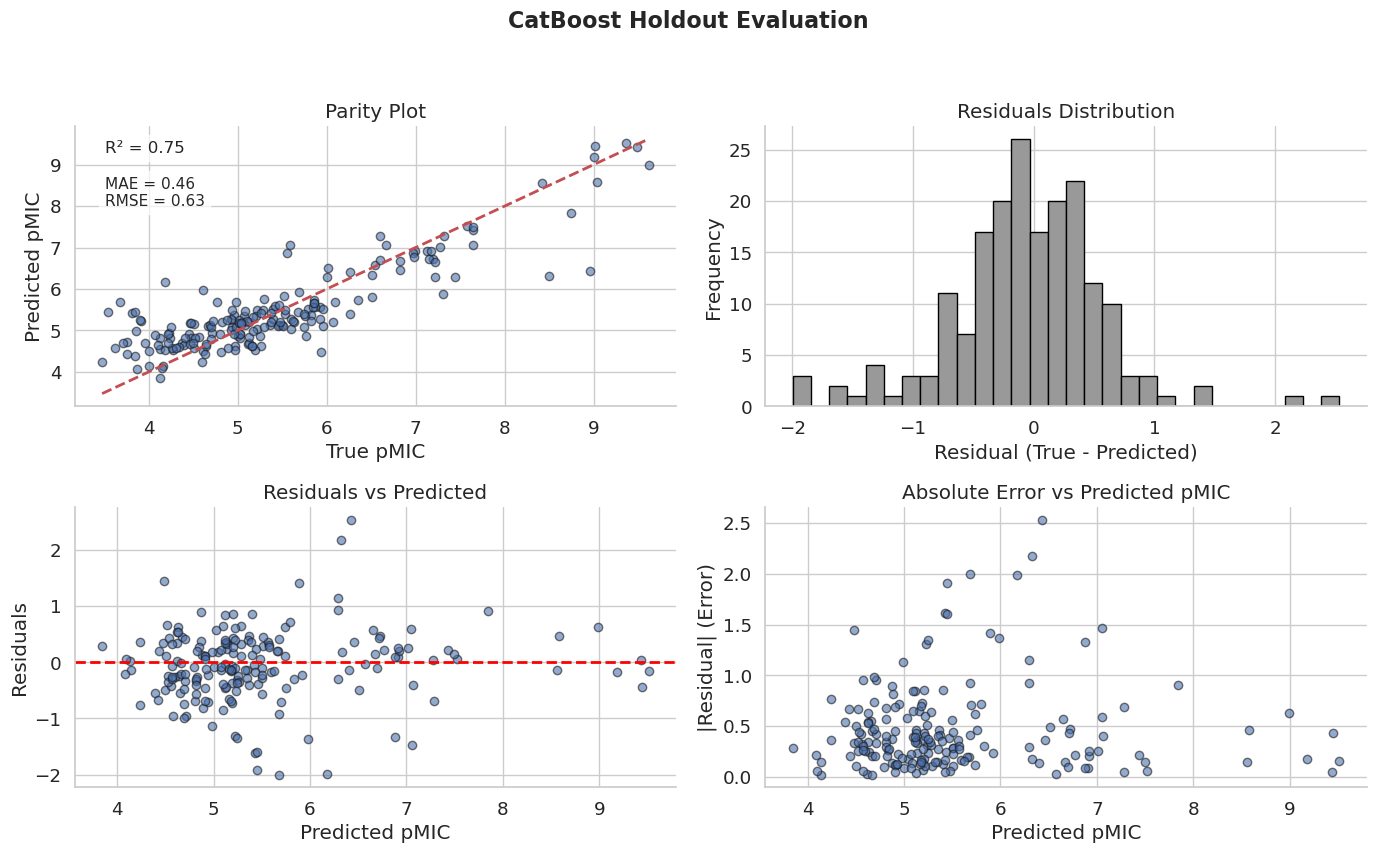

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import numpy as np

# Apply Seaborn style
sns.set(style="whitegrid", font_scale=1.2)


# Predict + residuals
y_pred_holdout = best_model.predict(X_holdout_clean)
residuals = y_holdout - y_pred_holdout
abs_errors = np.abs(residuals)

# Metrics
r2 = r2_score(y_holdout, y_pred_holdout)
mae = mean_absolute_error(y_holdout, y_pred_holdout)
rmse = np.sqrt(mean_squared_error(y_holdout, y_pred_holdout))

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(14, 9))
fig.suptitle("CatBoost Holdout Evaluation", fontsize=16, fontweight='bold')

# 1. Parity plot
axs[0, 0].scatter(y_holdout, y_pred_holdout, alpha=0.6, edgecolor='k')
axs[0, 0].plot([min(y_holdout), max(y_holdout)], [min(y_holdout), max(y_holdout)], 'r--', lw=2)
axs[0, 0].set_title("Parity Plot")
axs[0, 0].set_xlabel("True pMIC")
axs[0, 0].set_ylabel("Predicted pMIC")
axs[0, 0].text(0.05, 0.95, f"R² = {r2:.2f}", transform=axs[0, 0].transAxes,
               fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))
axs[0, 0].text(0.05, 0.82, f"MAE = {mae:.2f}\nRMSE = {rmse:.2f}",
               transform=axs[0, 0].transAxes, fontsize=11,
               verticalalignment='top', bbox=dict(facecolor='white', alpha=0.7))

# 2. Residual histogram
axs[0, 1].hist(residuals, bins=30, color='#999999', edgecolor='black')
axs[0, 1].set_title("Residuals Distribution")
axs[0, 1].set_xlabel("Residual (True - Predicted)")
axs[0, 1].set_ylabel("Frequency")

# 3. Residuals vs Predicted
axs[1, 0].scatter(y_pred_holdout, residuals, alpha=0.6, edgecolor='k')
axs[1, 0].axhline(0, color='red', linestyle='--', linewidth=2)
axs[1, 0].set_title("Residuals vs Predicted")
axs[1, 0].set_xlabel("Predicted pMIC")
axs[1, 0].set_ylabel("Residuals")

# 4. Absolute Error vs Predicted
axs[1, 1].scatter(y_pred_holdout, abs_errors, alpha=0.6, edgecolor='k')
axs[1, 1].set_title("Absolute Error vs Predicted pMIC")
axs[1, 1].set_xlabel("Predicted pMIC")
axs[1, 1].set_ylabel("|Residual| (Error)")

# Clean up spines
for ax in axs.flat:
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.savefig("best_model_test.png", dpi=300)
plt.show()

### 6. Y-randomization and 10-fold CV

In [ ]:
from sklearn.metrics import r2_score
import numpy as np
from sklearn.ensemble import RandomForestRegressor
import copy

# Set random seed for reproducibility
np.random.seed(42)

# Copy the trained model structure
rf_template = copy.deepcopy(best_model)

# Run scramble test
r2_scramble_scores = []
n_repeats = 100

for _ in range(n_repeats):
    # Shuffle y_main but keep X_main the same
    y_scrambled = np.random.permutation(y_main)

    # Train on scrambled data
    rf_scrambled = copy.deepcopy(rf_template)
    rf_scrambled.fit(X_main, y_scrambled)

    # Predict on untouched holdout set
    y_pred_scrambled = rf_scrambled.predict(X_holdout)

    # Compare to true holdout y
    r2_scramble_scores.append(r2_score(y_holdout, y_pred_scrambled))

# Report mean R²_scramble
r2_scramble_mean = np.mean(r2_scramble_scores)
print(f"R²_scramble (mean of {n_repeats} runs): {r2_scramble_mean:.3f}")

R²_scramble (mean of 100 runs): -0.141


In [ ]:
from sklearn.model_selection import cross_val_predict, KFold

cv = KFold(n_splits=10, shuffle=True, random_state=42)
y_pred_cv = cross_val_predict(best_model, X_main, y_main, cv=cv)
q2_kfold = r2_score(y_main, y_pred_cv)

print(f"Q²_10-fold: {q2_kfold:.3f}")

Q²_10-fold: 0.721


### 7. Applicability domain (Williams plot)

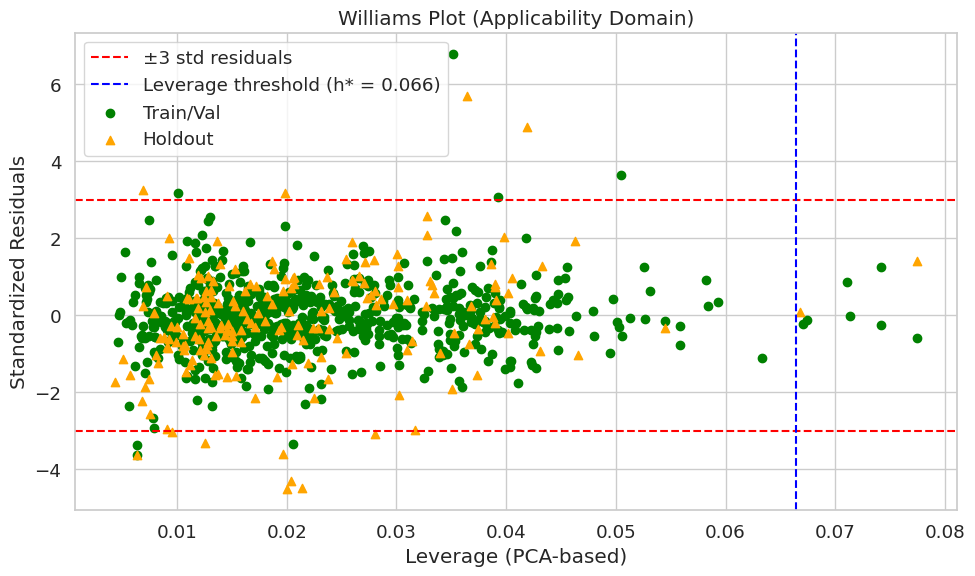

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA

# Convert data to DataFrames
X_main_df = pd.DataFrame(X_main, columns=[f'fp_{i}' for i in range(X_main.shape[1])])
X_holdout_df = pd.DataFrame(X_holdout, columns=X_main_df.columns)

y_main_series = pd.Series(y_main, name='pMIC')
y_holdout_series = pd.Series(y_holdout, name='pMIC')

# Predict
train_pred = pd.Series(best_model.predict(X_main_df), index=y_main_series.index)
test_pred = pd.Series(best_model.predict(X_holdout_df), index=y_holdout_series.index)

# Combine
X_total = pd.concat([X_main_df, X_holdout_df], ignore_index=True)
y_total = pd.concat([y_main_series, y_holdout_series], ignore_index=True)
y_pred_total = pd.concat([train_pred, test_pred], ignore_index=True)

# PCA transformation
pca = PCA(n_components=20)
X_pca = pca.fit_transform(X_total)

# Leverage via PCA space
X_pca_const = np.hstack([np.ones((X_pca.shape[0], 1)), X_pca])
H = X_pca_const @ np.linalg.pinv(X_pca_const.T @ X_pca_const) @ X_pca_const.T
leverage = np.diag(H)

# Standardized residuals
residuals = y_total - y_pred_total
std_residuals = residuals / np.std(residuals)

# Split train/test
n_train = len(X_main_df)
leverage_train, leverage_test = leverage[:n_train], leverage[n_train:]
std_resid_train, std_resid_test = std_residuals[:n_train], std_residuals[n_train:]

# Leverage threshold (in PCA space)
p = X_pca.shape[1]
n = X_pca.shape[0]
h_star = 3 * (p + 1) / n

# Plot
plt.figure(figsize=(10, 6))
plt.axhline(y=3, color='red', linestyle='--', label='±3 std residuals')
plt.axhline(y=-3, color='red', linestyle='--')
plt.axvline(x=h_star, color='blue', linestyle='--', label=f'Leverage threshold (h* = {h_star:.3f})')

plt.scatter(leverage_train, std_resid_train, c='green', label='Train/Val', marker='o')
plt.scatter(leverage_test, std_resid_test, c='orange', label='Holdout', marker='^')

plt.xlabel("Leverage (PCA-based)")
plt.ylabel("Standardized Residuals")
plt.title("Williams Plot (Applicability Domain)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("williams_cat_pca.png", dpi=300)
plt.show()

### 8. Check most influential compounds (outliers)

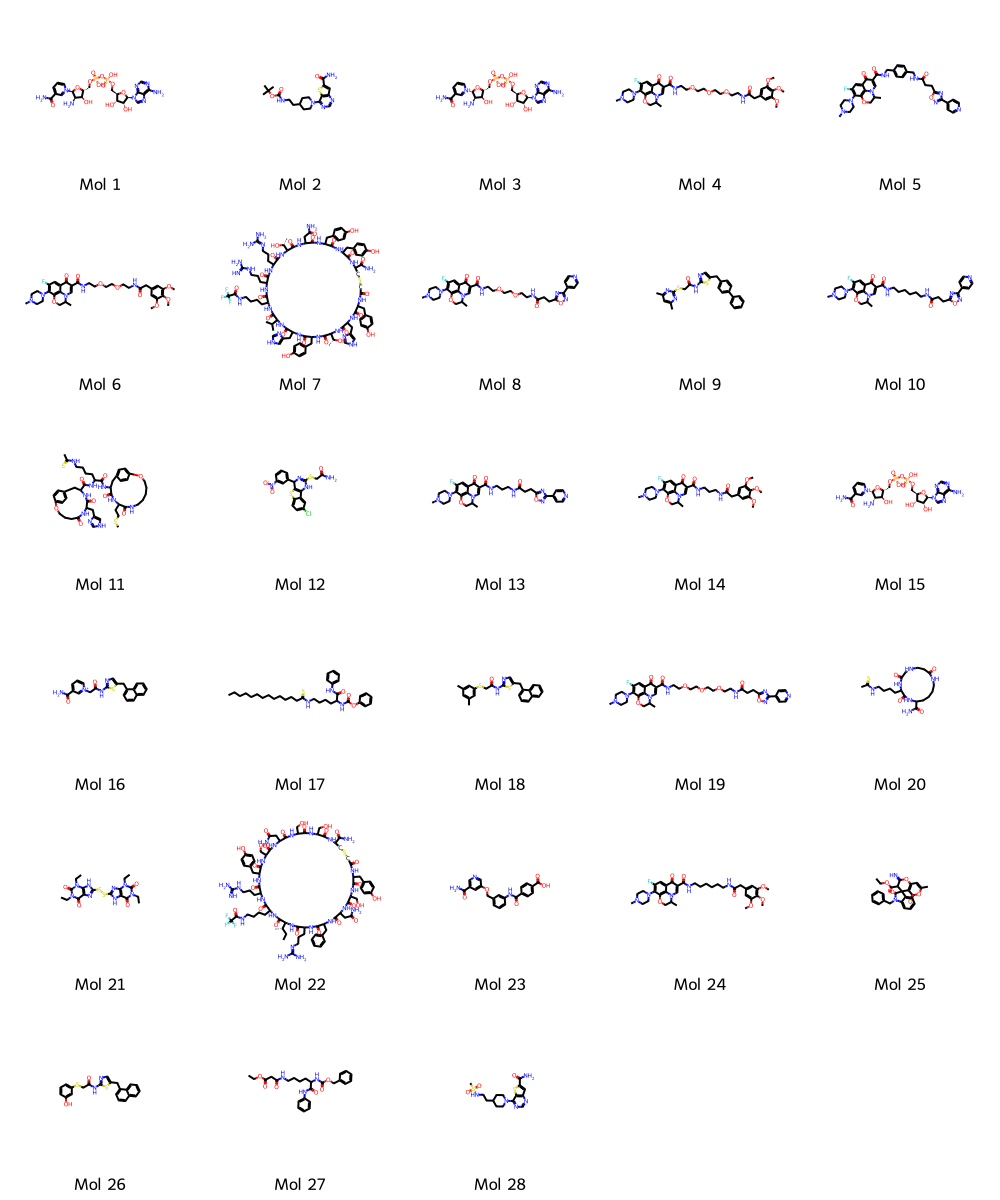

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# Ensure y and bins are same length as df_final
y = df_final['pIC50']
bins = pd.qcut(y, q=5, labels=False)

# Get indices
train_idx, holdout_idx = train_test_split(
    np.arange(len(df_final)),
    test_size=0.2,
    stratify=bins,
    random_state=42
)

# Redo the same split to get indices
X_dummy = np.zeros((df_final.shape[0], 10))  # just to match shape
_, _, y_dummy, _, train_idx, holdout_idx = train_test_split(
    X_dummy, y, np.arange(df_final.shape[0]),
    test_size=0.2, stratify=bins, random_state=42
)

# Combine indices
combined_indices = np.concatenate([train_idx, holdout_idx])

# Extract SMILES from df_final
all_smiles = df_final.loc[combined_indices, 'smiles'].reset_index(drop=True)

# Build DataFrame with leverage and residuals
combined_df = pd.DataFrame({
    "smiles": all_smiles,
    "leverage": leverage,
    "std_residual": std_residuals
})

# Leverage threshold
h_star = 3 * (X_pca.shape[1] + 1) / X_pca.shape[0]

# Flag influential
influential_df = combined_df[
    (combined_df["leverage"] > h_star) | (np.abs(combined_df["std_residual"]) > 3)
].copy()

# Convert SMILES to mols
influential_df["mol"] = influential_df["smiles"].apply(lambda x: Chem.MolFromSmiles(x))
influential_mols = [mol for mol in influential_df["mol"] if mol is not None]

# Draw top 20
img = Draw.MolsToGridImage(
    influential_mols[:30],
    molsPerRow=5,
    subImgSize=(200, 200),
    legends=[f"Mol {i+1}" for i in range(len(influential_mols[:30]))]
)
img

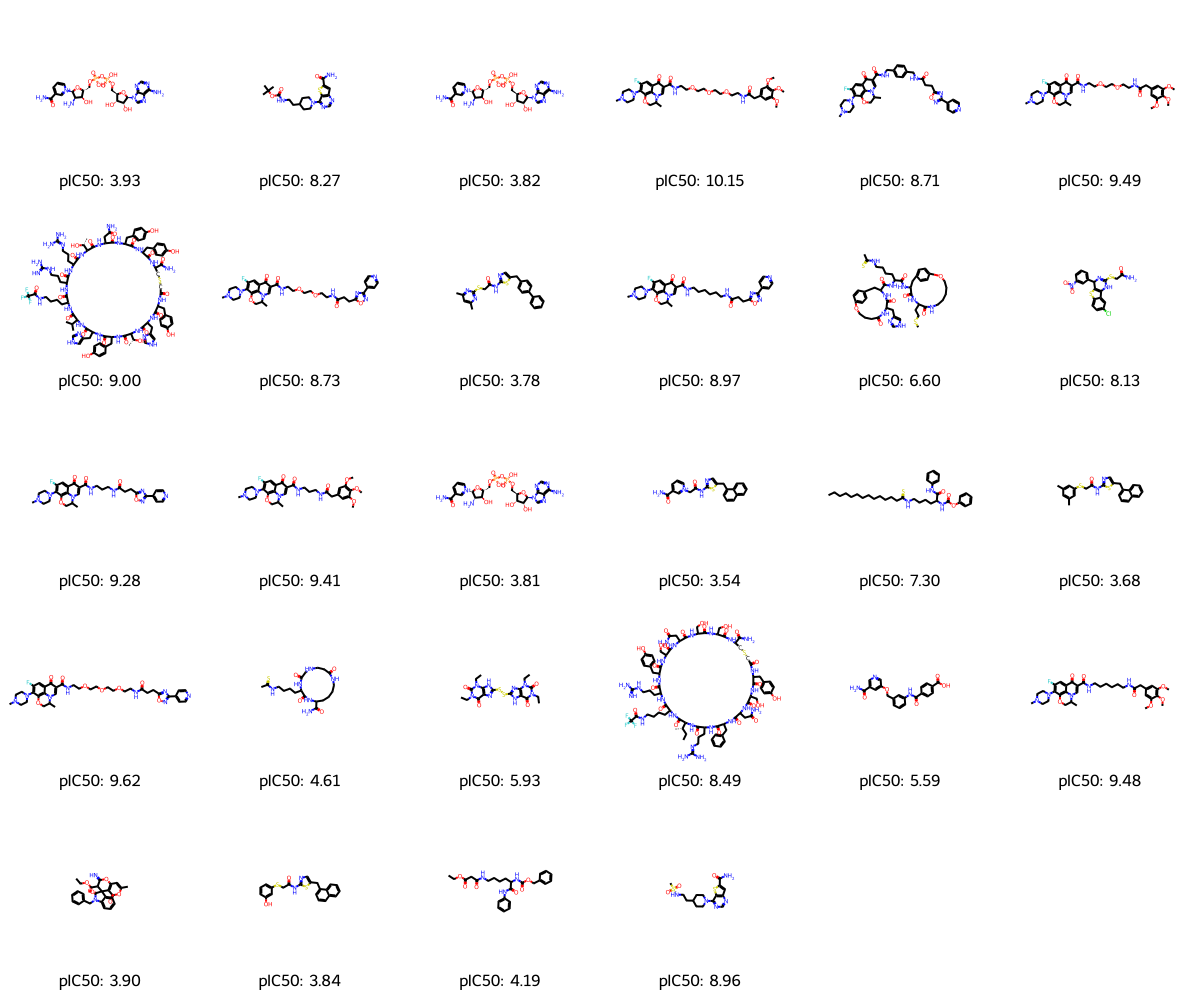

In [ ]:
# Collect corresponding pMIC values from y_total
influential_df["pIC50"] = y_total.iloc[influential_df.index].values

# Generate RDKit mols again just to be safe
influential_df["mol"] = influential_df["smiles"].apply(lambda x: Chem.MolFromSmiles(x))
influential_mols = [mol for mol in influential_df["mol"] if mol is not None]

# Legends with pIC50 values
legends = [f"pIC50: {val:.2f}" for val in influential_df["pIC50"].values[:30]]

# Draw
img = Draw.MolsToGridImage(
    influential_mols[:30],
    molsPerRow=6,
    subImgSize=(200, 200),
    legends=legends
)
img

### 9. Machine learning-based virtual screening

In [ ]:
# 1. Load drugbank dataset
import pandas as pd
drugbank_df = pd.read_csv("drugbank.csv")
drugbank_df

,DATABASE_ID,SMILES,DRUG_GROUPS
0,DB00006,CC[C@H](C)[C@H](NC(=O)[C@H](CCC(O)=O)NC(=O)[C@...,approved; investigational
1,DB00014,CC(C)C[C@H](NC(=O)[C@@H](COC(C)(C)C)NC(=O)[C@H...,approved
2,DB00027,CC(C)C[C@@H](NC(=O)CNC(=O)[C@@H](NC=O)C(C)C)C(...,approved
3,DB00035,NC(=O)CC[C@@H]1NC(=O)[C@H](CC2=CC=CC=C2)NC(=O)...,approved
4,DB00050,CC(C)C[C@H](NC(=O)[C@@H](CCCNC(N)=O)NC(=O)[C@H...,approved; investigational
...,...,...,...
12302,DB19446,[H][C@@]1(CC[C@@H](CC1)N1CC(C1)OC)[C@@]1(C)OC2...,investigational
12303,DB19451,COC(=O)N[C@H](C(=O)N1C[C@@H](C[C@H]1C(=O)N[C@@...,investigational
12304,DB19454,CCCCCCCCCCCCCCCCOC(=O)CCCCCCC\C=C/CCCCCCCC,investigational
12305,DB19455,CCCCCCCCCCCCCCCCOC(=O)CCCCCCC\C=C/CCCC,investigational


In [ ]:
from rdkit import Chem, RDLogger
from rdkit.Chem import SaltRemover
from rdkit.Chem.MolStandardize import rdMolStandardize

# Silence RDKit logs
RDLogger.DisableLog('rdApp.*')

remover = SaltRemover.SaltRemover()
normalizer = rdMolStandardize.Normalizer()
uncharger = rdMolStandardize.Uncharger()
tautomer_enumerator = rdMolStandardize.TautomerEnumerator()

def standardize_smiles(smiles):
    if pd.isnull(smiles):
        return smiles
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    mol = remover.StripMol(mol)
    mol = normalizer.normalize(mol)
    mol = uncharger.uncharge(mol)
    mol = tautomer_enumerator.Canonicalize(mol)
    return Chem.MolToSmiles(mol, canonical=True)

drugbank_df['SMILES'] = drugbank_df['SMILES'].apply(standardize_smiles)

In [ ]:
# Compute Ghose properties
from rdkit.Chem import Descriptors, Crippen

def compute_ghose(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return pd.Series([None] * 4)
    mw = Descriptors.MolWt(mol)
    logp = Crippen.MolLogP(mol)
    atoms = mol.GetNumAtoms()
    mr = Crippen.MolMR(mol)  # <- here
    return pd.Series([mw, logp, atoms, mr])

drugbank_df[['MW', 'LogP', 'NumAtoms', 'MR']] = drugbank_df['SMILES'].apply(compute_ghose)

# Apply Ghose filter
ghose_filter = (
    (drugbank_df['MW'] >= 160) & (drugbank_df['MW'] <= 480) &
    (drugbank_df['LogP'] >= -0.4) & (drugbank_df['LogP'] <= 5.6) &
    (drugbank_df['NumAtoms'] >= 20) & (drugbank_df['NumAtoms'] <= 70) &
    (drugbank_df['MR'] >= 40) & (drugbank_df['MR'] <= 130)
)

# Filter and drop descriptors
drugbank_ghose = drugbank_df[ghose_filter].drop(columns=['MW', 'LogP', 'NumAtoms', 'MR'])

# Save
drugbank_ghose.to_csv("drugbank_ghose.csv", index=False)

In [ ]:
drugbank_ghose = pd.read_csv("drugbank_ghose.csv")
drugbank_ghose

,DATABASE_ID,SMILES,DRUG_GROUPS
0,DB00116,Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)NC(CCC(=O)...,nutraceutical
1,DB00158,Nc1nc(=O)c2nc(CNc3ccc(C(=O)NC(CCC(=O)O)C(=O)O)...,approved; nutraceutical; vet_approved
2,DB00162,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/CO)C(C)(C)CCC1,approved; nutraceutical; vet_approved
3,DB00168,COC(=O)C(Cc1ccccc1)NC(=O)C(N)CC(=O)O,investigational; nutraceutical
4,DB00175,CCC(C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H...,approved
...,...,...,...
4942,DB19360,O=C(O)CCC/C=C\C[C@@H]1[C@@H](CC[C@@H](O)CCc2cc...,approved
4943,DB19367,CCN(CC)CCSC(=O)C(c1ccccc1)c1ccccc1,investigational
4944,DB19378,CC(=O)[C@@]1(O)CC[C@H]2C3=CC(C)=C4CC(=O)CC[C@]...,approved
4945,DB19383,CCC(C)C(C(=O)OC1CC[N+](C)(C)CC1)c1ccccc1,withdrawn


In [ ]:
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
from tqdm import tqdm

# ECFP4 generator
def get_ecfp4_array(smiles, nBits=2048):
    mol = Chem.MolFromSmiles(smiles)
    if mol:
        fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=nBits)
        return list(fp)
    else:
        return None

# Enable tqdm progress
tqdm.pandas()

# Apply on your final dataset with progress bar
drugbank_ghose['ecfp4'] = drugbank_ghose['SMILES'].progress_apply(get_ecfp4_array)

# Drop any failed rows
drugbank_ghose = drugbank_ghose[drugbank_ghose['ecfp4'].notnull()].reset_index(drop=True)

# Expand fingerprints to 2048 columns
fp_df = pd.DataFrame(drugbank_ghose['ecfp4'].to_list(), columns=[f'fp_{i}' for i in range(2048)])

# Join and save
drugbank_fp = pd.concat([drugbank_ghose.drop(columns=['ecfp4']), fp_df], axis=1)
drugbank_fp.to_csv("drugbank_ghose_ecfp4.csv", index=False)

100%|█████████████████████████████████████████████████████████████████████████████| 4947/4947 [00:02<00:00, 1656.19it/s]


In [ ]:
drugbank_fp

,DATABASE_ID,SMILES,DRUG_GROUPS,fp_0,fp_1,fp_2,fp_3,fp_4,fp_5,fp_6,...,fp_2038,fp_2039,fp_2040,fp_2041,fp_2042,fp_2043,fp_2044,fp_2045,fp_2046,fp_2047
0,DB00116,Nc1nc(=O)c2c([nH]1)NCC(CNc1ccc(C(=O)NC(CCC(=O)...,nutraceutical,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1,DB00158,Nc1nc(=O)c2nc(CNc3ccc(C(=O)NC(CCC(=O)O)C(=O)O)...,approved; nutraceutical; vet_approved,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,DB00162,CC1=C(/C=C/C(C)=C/C=C/C(C)=C/CO)C(C)(C)CCC1,approved; nutraceutical; vet_approved,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,DB00168,COC(=O)C(Cc1ccccc1)NC(=O)C(N)CC(=O)O,investigational; nutraceutical,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,DB00175,CCC(C)C(=O)O[C@H]1C[C@H](O)C=C2C=C[C@H](C)[C@H...,approved,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4942,DB19360,O=C(O)CCC/C=C\C[C@@H]1[C@@H](CC[C@@H](O)CCc2cc...,approved,0,1,0,0,0,0,0,...,1,1,0,0,0,0,0,0,0,0
4943,DB19367,CCN(CC)CCSC(=O)C(c1ccccc1)c1ccccc1,investigational,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4944,DB19378,CC(=O)[C@@]1(O)CC[C@H]2C3=CC(C)=C4CC(=O)CC[C@]...,approved,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4945,DB19383,CCC(C)C(C(=O)OC1CC[N+](C)(C)CC1)c1ccccc1,withdrawn,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
import joblib

best_model = joblib.load('best_model.pkl')

In [ ]:
# Use selected features from training
fp_cols_selected = X_main_clean.columns.tolist()

# Apply same features to DrugBank
X_drugbank = drugbank_fp[fp_cols_selected]

# Predict and add results
drugbank_fp['Predicted_pIC50'] = best_model.predict(X_drugbank)

# Drop fingerprint cols before saving
drugbank_fp.drop(columns=fp_cols_selected).to_csv("drugbank_predictions.csv", index=False)

### 10. Applicability domain for predicted compounds (Mahalanobis distance)

In [ ]:
import numpy as np
import pandas as pd
from scipy.spatial import distance
from scipy.stats import chi2
from sklearn.decomposition import PCA

# 1. Get selected feature columns used in model training
model_features = X_main.columns
X_train_ad = X_main[model_features]
X_drugbank = drugbank_fp[model_features]

# 2. Apply PCA (reduce to 20 components)
n_components = 20
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_ad)
X_drugbank_pca = pca.transform(X_drugbank)

# 3. Compute Mahalanobis distance for each DrugBank compound
mean_vec = np.mean(X_train_pca, axis=0)
cov_matrix = np.cov(X_train_pca, rowvar=False)
inv_cov_matrix = np.linalg.pinv(cov_matrix)

mahal_dist = np.array([
    distance.mahalanobis(x, mean_vec, inv_cov_matrix)
    for x in X_drugbank_pca
])

# 4. Calculate threshold at 95% confidence level
threshold = np.sqrt(chi2.ppf(0.95, df=n_components))

# 5. Predict pIC50 for DrugBank compounds
y_pred_drugbank = best_model.predict(X_drugbank)

# 6. Annotate DrugBank DataFrame
drugbank_fp['Predicted_pIC50'] = y_pred_drugbank
drugbank_fp['Mahalanobis'] = mahal_dist
drugbank_fp['Inside_AD'] = mahal_dist <= threshold

# 7. Save selected columns
columns_to_keep = ['DATABASE_ID', 'SMILES', 'DRUG_GROUPS', 'Predicted_pIC50', 'Mahalanobis', 'Inside_AD']
drugbank_fp[columns_to_keep].to_csv("drugbank_with_mahalanobis_ad.csv", index=False)